In [1]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_GC import CAdaptive_GC_RK4
from adaptive_GC_sqrt import CAdaptive_GC_RK4_sqrt
import matplotlib.pyplot as plt
import time

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def apply_method(H, S, num_electrons, beta, eps):
    # Invert S for calculation
    inv_S = linalg.inv(S)
    
    # Define chemical potential
    core_spec = linalg.eigvalsh(H, S)
    index = int(num_electrons / 2)
    mu = (core_spec[index] + core_spec[index - 1]) / 2
    
    # Define dbeta
    dbeta = beta / 10000
    
    # Run our GC method
    gc = CAdaptive_GC_RK4(ovlp=S, H=H, mu=mu, dbeta=dbeta, epsilon=eps)
    gc.propagate(beta)
    
    return gc

In [4]:
def get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    return S @ linalg.funm(inv_S @ H, lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

In [5]:
def successive(H, S, num_electrons, beta):
    # Define dbeta
    dbeta = beta / 10000
    
    # Define chemical potential
    core_spec = linalg.eigvalsh(H, S)
    index = int(num_electrons / 2)
    mu = (core_spec[index] + core_spec[index - 1]) / 2
    
    # Create dictionary of common parameters
    params = dict(ovlp=S, H=H, mu=mu)
    
    # Create list of epsilon values to use
    eps = [1e-1, 1e-2, 1e-3, 1e-4]
    
    # Create list for storing results
    results = []
    
    # Run the first step and append to list
    gc = CAdaptive_GC_RK4(dbeta=dbeta, epsilon=5e-2, **params)
    gc.propagate(beta)
    results.append(gc)
    
    # Run second step and append
    gc2 = CAdaptive_GC_RK4(dbeta=gc.dbeta, epsilon=1e-2, rho=gc.rho, beta=gc.beta, **params)
    gc2.propagate(beta)
    results.append(gc2)
    
    # Run third step and append
    gc3 = CAdaptive_GC_RK4(dbeta=gc2.dbeta, epsilon=1e-3, rho=gc2.rho, beta=gc2.beta, **params)
    gc3.propagate(beta)
    results.append(gc3)
    """
    # Run final step and append
    gc4 = CAdaptive_GC_RK4(dbeta=gc3.dbeta, epsilon=1e-4, rho=gc3.rho, beta=gc3.beta, **params)
    gc4.propagate(beta)
    results.append(gc4)
    """
    
    return results

In [6]:
def plot_results_fd_vs_gc(num_electrons, fd, gc):
    H = gc.H
    S = gc.ovlp
    
    # Plot final eigenvalue spectra of the exact solution and our methods results
    plt.figure(1)
    #plt.title("Populations - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(fd, S)[::-1], 'ks-', label="Exact by FD")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(gc.rho, S)[::-1], 'r^-', label="Grand Can. DMM")
    #plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_pop.png", format='png', dpi=300)
    print(gc.beta)
    
    # Plot increments of dbeta that our method took
    plt.figure(2)
    plt.title("Variable step method in action - " + str(num_electrons) + "electrons")
    plt.plot(gc.beta_increments, '*-')
    plt.xlabel('steps')
    plt.ylabel('dbeta')
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_dbeta_inc.png", format='png', dpi=300)
    
    # Plot number of electrons
    plt.figure(3)
    plt.title("Change in number of electrons - " + str(num_electrons) + " electrons")
    plt.plot(gc.num_electron_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("num_electrons")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_num_electrons.png", format='png', dpi=300)
    
    # Plot chemical potential
    plt.figure(4)
    plt.title("Change in chemical potential - " + str(num_electrons) + " electrons")
    plt.plot(gc.mu_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("mu")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_chem_pot.png", format='png', dpi=300)
    """
    # Imshow of eigenvalues
    plt.figure(5)
    plt.imshow(np.array(gc.eigenvalues).real, origin='lower', aspect='1')
    plt.xlabel("eigenvalues")
    plt.ylabel("steps")
    plt.title("Imshow of eigenvalues - " + str(num_electrons) + " electrons")
    plt.colorbar()
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_eig_imshow.png", format='png', dpi=300)
    """
    # Check beta vs step size
    beta_vals = np.cumsum(gc.beta_increments)
    plt.figure(6)
    plt.plot(gc.beta_increments, beta_vals)
    plt.xlabel("dbeta")
    plt.ylabel("beta")
    plt.title("beta vs step size - " + str(num_electrons) + " electrons")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_beta_vs_stepsize.png", format='png', dpi=300)
    
    # Plot energy values
    plt.figure(7)
    plt.title("Energy values vs temp - " + str(num_electrons) + " electrons")
    plt.plot(beta_vals, (gc.energy_vals - min(gc.energy_vals))[:-1])
    plt.xlabel("beta")
    plt.ylabel("E(beta) - min(E)")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_energy_vs_beta.png", format='png', dpi=300)
    
    # Plot energy values
    plt.figure(8)
    plt.title("Energy values vs steps - " + str(num_electrons) + " electrons")
    plt.semilogy((gc.energy_vals - min(gc.energy_vals))[:-1])
    plt.xlabel("steps")
    plt.ylabel("E(step) - E.min")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_energy_vs_steps.png", format='png', dpi=300)
    
    # Plot heat capacity
    plt.figure(9)
    plt.title("Heat capacity vs temp - " + str(num_electrons) + " electrons")
    t_vals = 1 / np.cumsum(gc.beta_increments)
    plt.plot(t_vals[:10], gc.cv[:10])
    plt.xlabel("T")
    plt.ylabel("C_v")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_cv.png", format='png', dpi=300)

In [7]:
def successive_plots(num_electrons, gc_direct, gc_succ):
    H = gc_direct.H
    S = gc_direct.ovlp
    
    # Combine eigenvalues from successive steps
    gc_succ_eigenvalues = np.vstack(
        [_.eigenvalues for _ in gc_succ]
    )

    # Combine beta increments from successive steps
    gc_succ_beta_increments = np.hstack(
        [_.beta_increments for _ in gc_succ]
    )

    # Plot beta increments
    plt.figure(1)
    plt.title("Successive dbeta changes - " + str(num_electrons) + " electrons")
    plt.semilogy(gc_succ_beta_increments)
    plt.xlabel("steps")
    plt.ylabel("dbeta")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_successive_dbeta_inc.png", format='png', dpi=300)
    
    """
    # Print final beta of successive steps and imshow eigenvalue spectra
    print(gc_succ[-1].beta)
    plt.figure(2)
    plt.title("Successive Eigenvalues - " + str(num_electrons) + " electrons")
    plt.imshow(gc_succ_eigenvalues.real, origin='lower', aspect=1)
    plt.xlabel("Population Index")
    plt.ylabel("Steps")
    plt.colorbar()
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_successive_eig_imshow.png", format='png', dpi=300)
    """
    
    # Print results for direct and successive approaches
    plt.figure(3)
    plt.title("Direct vs Successive - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(gc_succ[-1].rho, S)[::-1], '*-', label="Successive")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(gc_direct.rho, S)[::-1], '*-', label="Direct")
    plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_direct_vs_successive_pops.png", format='png', dpi=300)
    
    # Combine beta increments from successive steps
    gc_succ_energy_vals = np.hstack(
        [_.energy_vals for _ in gc_succ]
    )
    plt.figure(4)
    plt.title("Energy values - " + str(num_electrons) + " electrons")
    plt.plot(gc_succ_energy_vals)
    plt.xlabel("Steps")
    plt.ylabel("Energy")
    plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/GC_successive_energy_vals.png", format='png', dpi=300)

In [8]:
def plot_results_omega_vs_P(num_electrons, sqrt_gc, gc):
    H = gc.H
    S = gc.ovlp
    rho = sqrt_gc.omega.conj().T @ sqrt_gc.omega
    num_fig = 1
    
    # Plot final eigenvalue spectra of the exact solution and our methods results
    plt.figure(num_fig)
    #plt.title("Populations - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(gc.rho, S)[::-1], 'r^-', label="Normal")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(rho, S)[::-1], 'bo', label="Sqrt")
    plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/sqrt_vs_normal.png", format='png', dpi=300)
    print(gc.beta)
    num_fig += 1
    
    # Plot increments of dbeta that our method took
    plt.figure(num_fig)
    plt.title("Variable step method in action - " +str(num_electrons) + " electrons")
    plt.plot(gc.beta_increments, 'r^-', label='Normal')
    plt.plot(sqrt_gc.beta_increments, 'bo', label='Sqrt')
    plt.xlabel('steps')
    plt.ylabel('dbeta')
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_dbeta_inc.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot number of electrons
    plt.figure(num_fig)
    plt.title("Change in number of electrons - " + str(num_electrons) + " electrons")
    plt.plot(gc.num_electron_list, 'r^-', label='Normal')
    plt.plot(sqrt_gc.num_electron_list, 'bo', label='Sqrt')
    plt.xlabel("steps")
    plt.ylabel("num_electrons")
    plt.ylim([31, 33])
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_num_electrons.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot chemical potential
    plt.figure(num_fig)
    plt.title("Change in chemical potential - " + str(num_electrons) + " electrons")
    plt.plot(gc.mu_list, 'r^-', label='Normal')
    plt.plot(sqrt_gc.mu_list, 'bo', label='Sqrt')
    plt.xlabel("steps")
    plt.ylabel("mu")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_chem_pot.png", format='png', dpi=300)
    num_fig += 1
    
    # Check beta vs step size
    plt.figure(num_fig)
    beta_vals = np.cumsum(gc.beta_increments)
    sqrt_beta_vals = np.cumsum(sqrt_gc.beta_increments)
    print(beta_vals[0])
    plt.plot(gc.beta_increments, beta_vals, 'r^-', label='Normal')
    plt.plot(sqrt_gc.beta_increments, sqrt_beta_vals, 'bo', label='Sqrt')
    plt.xlabel("dbeta")
    plt.ylabel("beta")
    plt.title("beta vs step size - " + str(num_electrons) + " electrons")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_beta_vs_stepsize.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot energy values
    plt.figure(num_fig)
    plt.title("Energy values vs temp - " + str(num_electrons) + " electrons")
    plt.semilogy(beta_vals, (gc.energy_vals - min(gc.energy_vals))[:-1], 'r^-', label='Normal')
    plt.semilogy(sqrt_beta_vals, (sqrt_gc.energy_vals - min(sqrt_gc.energy_vals))[:-1], 'bo', label='Sqrt')
    plt.xlabel("beta")
    plt.ylabel("E(beta) - E.min")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_energy_vs_beta.png", format='png', dpi=300)
    num_fig += 1
    
    # Plot energy values
    plt.figure(num_fig)
    plt.title("Energy values vs steps - " + str(num_electrons) + " electrons")
    plt.semilogy((gc.energy_vals - min(gc.energy_vals))[:-1], 'r^-', label='Normal')
    plt.semilogy((sqrt_gc.energy_vals - min(gc.energy_vals))[:-1], 'bo', label='Sqrt')
    plt.xlabel("steps")
    plt.ylabel("E(step) - E.min")
    plt.legend(numpoints=1)
    #plt.savefig("larger_matrices/figs/" + str(num_electrons) + "/C_energy_vs_steps.png", format='png', dpi=300)
    num_fig += 1

### Start with 16x16 case

In [9]:
# Define path for matrices
matrices_path = "larger_matrices/"

In [10]:
# Define path to H and S matrices
H_16= mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()
print(S_16 @ S_16.conj().T)

# Define num_electrons and beta
num_electrons = 32
beta = 1000

# Run method
gc_16 = apply_method(H_16, S_16, num_electrons, beta, 1e-2)
ferm_exact_16 = get_exact(H_16, S_16, num_electrons, gc_16.beta, gc_16.mu)

[[ 1.93840307e+00  2.31756091e-17  3.87756944e-16 ...  1.56313937e-01
   3.73150053e-01 -5.05534202e-18]
 [ 2.31756091e-17  1.71531130e+00 -4.58558610e-18 ...  2.39317834e-01
   3.15892522e-01  2.35601135e-01]
 [ 3.87756944e-16 -4.58558610e-18  1.73360783e+00 ... -1.55424753e-01
   2.54898202e-01 -1.57144566e-19]
 ...
 [ 1.56313937e-01  2.39317834e-01 -1.55424753e-01 ...  1.69875284e+00
   1.95827124e-18  7.08108233e-17]
 [ 3.73150053e-01  3.15892522e-01  2.54898202e-01 ...  1.95827124e-18
   1.78427888e+00 -1.71804576e-18]
 [-5.05534202e-18  2.35601135e-01 -1.57144566e-19 ...  7.08108233e-17
  -1.71804576e-18  1.79926105e+00]]
Energy_next > energy
funm result may be inaccurate, approximate err = 1


141.20232382837696


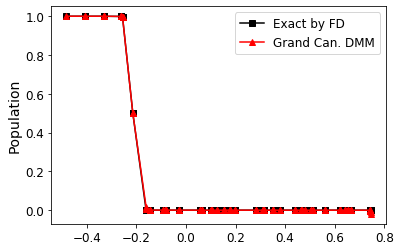

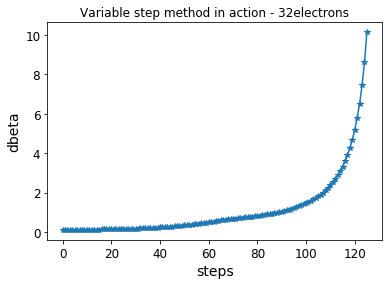

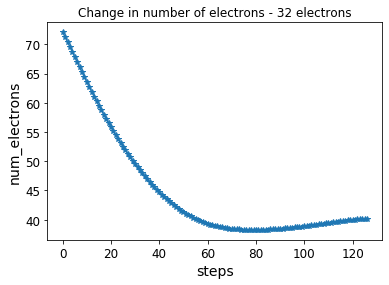

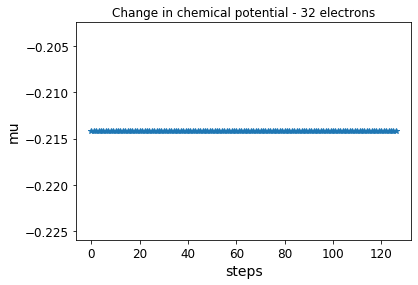

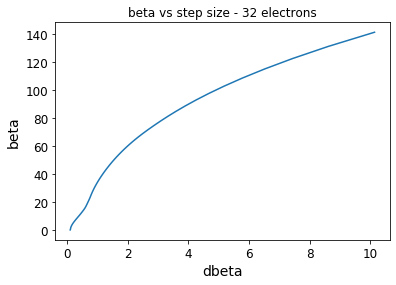

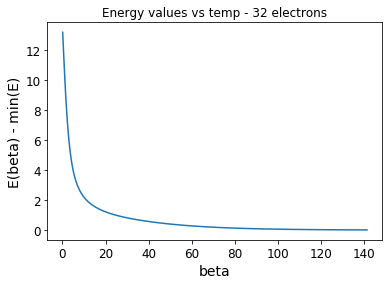

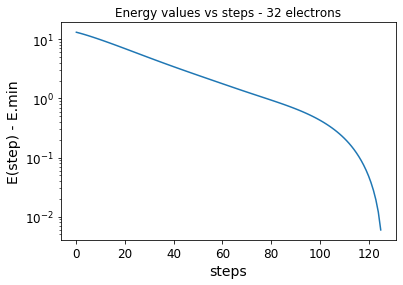

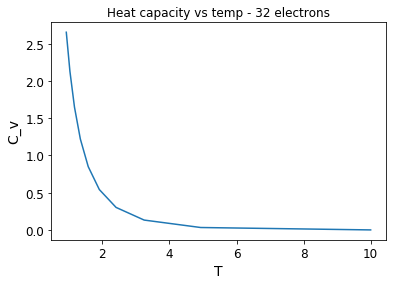

In [11]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_16, gc_16)

In [12]:
# Check sqrt method
core_spec = linalg.eigvalsh(H_16, S_16)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

dbeta = beta / 10000

sqrt_gc_16 = CAdaptive_GC_RK4_sqrt(ovlp=S_16, H=H_16, mu=mu, dbeta=dbeta, epsilon=1e-2)
sqrt_gc_16.propagate(beta)

Energy_next > energy


array([[ 5.40015804e-01+0.j, -2.61313430e-08+0.j, -2.26594969e-08+0.j,
        ...,  1.16721902e-04+0.j,  1.01771936e-01+0.j,
         1.01946790e-06+0.j],
       [-2.10026994e-09+0.j,  2.76568711e-01+0.j,  1.25748267e-08+0.j,
        ...,  2.73784534e-02+0.j,  2.74825503e-05+0.j,
         5.39677847e-02+0.j],
       [-1.76939924e-09+0.j, -1.40723696e-09+0.j,  2.56794767e-01+0.j,
        ..., -3.00087696e-02+0.j, -7.47049647e-07+0.j,
        -1.01449234e-07+0.j],
       ...,
       [ 6.54857112e-05+0.j,  2.13362666e-02+0.j, -2.26274977e-02+0.j,
        ...,  2.34290037e-02+0.j, -5.60195832e-07+0.j,
        -2.52839278e-07+0.j],
       [ 6.34537862e-02+0.j,  1.95422450e-05+0.j,  1.41343103e-08+0.j,
        ..., -1.27091599e-09+0.j,  7.15620190e-02+0.j,
         1.83028273e-08+0.j],
       [-3.54516598e-10+0.j,  4.56969376e-02+0.j,  4.73888586e-09+0.j,
        ...,  7.39060304e-09+0.j,  6.63479557e-07+0.j,
         1.27641054e-01+0.j]])

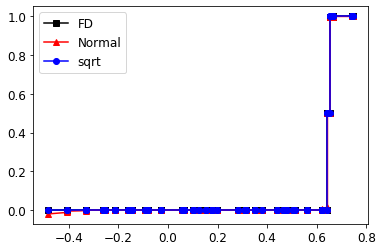

In [13]:
n = 0
plt.plot(linalg.eigvalsh(H_16, S_16)[n:], linalg.eigvalsh(ferm_exact_16, S_16)[n:], 'ks-', label='FD')
plt.plot(linalg.eigvalsh(H_16, S_16)[n:], linalg.eigvalsh(gc_16.rho, S_16)[n:], 'r^-', label='Normal')
rho = sqrt_gc_16.omega.conj().T @ sqrt_gc_16.omega
#rho = S_16 @ sqrt_gc.q @ sqrt_gc.q.conj().T
plt.plot(linalg.eigvalsh(H_16, S_16)[n:], linalg.eigvalsh(rho, S_16)[n:], 'bo-', label='sqrt')
plt.legend(numpoints=1)

141.20232382837696
0.1


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


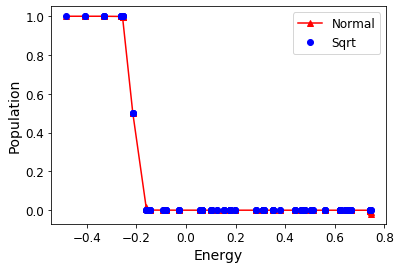

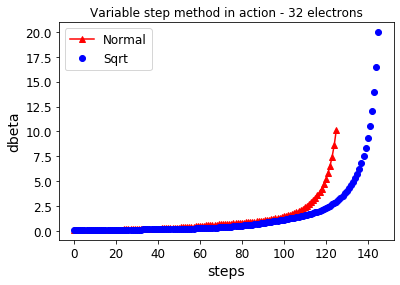

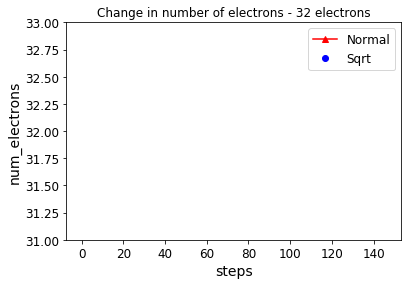

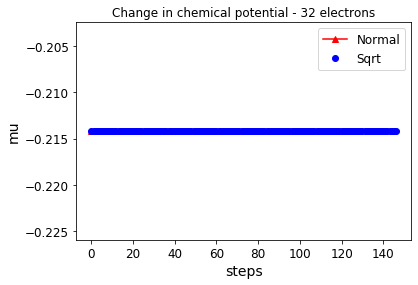

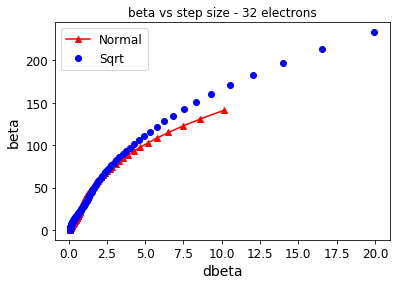

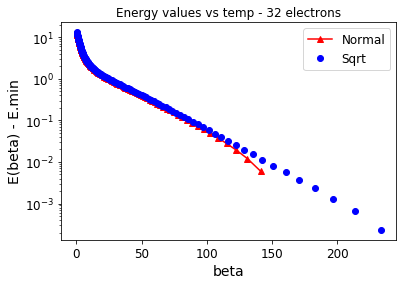

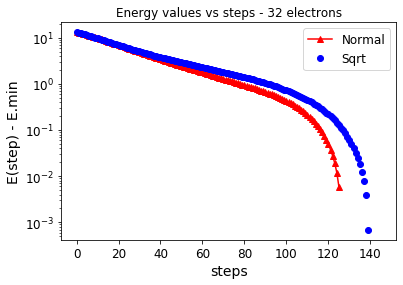

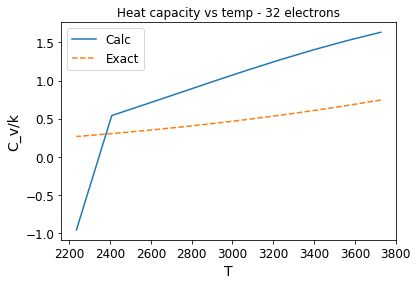

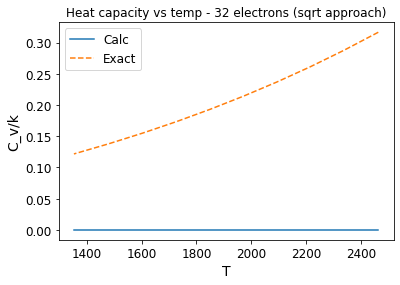

In [14]:
plot_results_omega_vs_P(num_electrons, sqrt_gc_16, gc_16)

In [ ]:
# Use successive steps
gc_succ_16 = successive(H_16, S_16, 16, 1000)

In [ ]:
successive_plots(num_electrons, gc_16, gc_succ_16)

### 54 x 54 case

In [ ]:
# Define path to H and S matrices
H_54 = mmread(matrices_path + "54_H.mtx").toarray()
S_54 = mmread(matrices_path + "54_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 108

# Run method
gc_54 = apply_method(H_54, S_54, num_electrons, beta, 1e-2)
ferm_exact_54 = get_exact(H_54, S_54, num_electrons, gc_54.beta, gc_54.mu)

In [ ]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_54, gc_54)

In [ ]:
# Use successive steps
gc_succ_54 = successive(H_54, S_54, num_electrons, beta)

In [ ]:
successive_plots(num_electrons, gc_54, gc_succ_54)

In [ ]:
# Check sqrt method
core_spec = linalg.eigvalsh(H_54, S_54)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

sqrt_gc_54 = CAdaptive_GC_RK4_sqrt(ovlp=S_54, H=H_54, mu=mu, dbeta=dbeta, epsilon=1e-2)
sqrt_gc_54.propagate(beta)

In [ ]:
plot_results_omega_vs_P(num_electrons, sqrt_gc_54, gc_54)

### 128 x 128 case

In [ ]:
# Define path to H and S matrices
H_128 = mmread(matrices_path + "128_H.mtx").toarray()
S_128 = mmread(matrices_path + "128_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 256

# Run method
gc_128 = apply_method(H_128, S_128, num_electrons, beta, 1e-2)
ferm_exact_128 = get_exact(H_128, S_128, num_electrons, gc_128.beta, gc_128.mu)

In [ ]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_128, gc_128)

In [ ]:
# Use successive steps
gc_succ_128 = successive(H_128, S_128, num_electrons, beta)

In [ ]:
successive_plots(num_electrons, gc_128, gc_succ_128)

In [ ]:
# Check sqrt method
core_spec = linalg.eigvalsh(H_128, S_128)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

sqrt_gc_128 = CAdaptive_GC_RK4_sqrt(ovlp=S_128, H=H_128, mu=mu, dbeta=dbeta, epsilon=1e-2)
sqrt_gc_128.propagate(beta)

In [ ]:
plot_results_omega_vs_P(num_electrons, sqrt_gc_128, gc_128)

### 250 x 250 case

In [ ]:
# Define path to H and S matrices
H_250 = mmread(matrices_path + "250_H.mtx").toarray()
S_250 = mmread(matrices_path + "250_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 500

# Run method
gc_250 = apply_method(H_250, S_250, num_electrons, beta, 1e-2)
ferm_exact_250 = get_exact(H_250, S_250, num_electrons, gc_250.beta, gc_250.mu)

In [ ]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_250, gc_250)

In [ ]:
# Use successive steps
gc_succ_250 = successive(H_250, S_250, num_electrons, beta)

In [ ]:
successive_plots(num_electrons, gc_250, gc_succ_250)

In [ ]:
# Check sqrt method
core_spec = linalg.eigvalsh(H_250, S_250)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

sqrt_gc_250 = CAdaptive_GC_RK4_sqrt(ovlp=S_250, H=H_250, mu=mu, dbeta=dbeta, epsilon=1e-2)
sqrt_gc_250.propagate(beta)

In [ ]:
plot_results_omega_vs_P(num_electrons, sqrt_gc_250, gc_250)

In [ ]:
x = [1, 2, 3, 4]
y = [len(gc_16.energy_vals), len(gc_54.energy_vals), len(gc_128.energy_vals), \
     len(gc_250.energy_vals)]
ax = plt.subplot()
ax.bar(x, y)
ax.set_ylabel("Number of Steps")
ax.set_xticklabels(['16', '54', '128', '250'])
ax.set_xticks(x)
#ax.set_xlabel("Num atoms")
#plt.title("GC Steps vs Num Atoms")
plt.savefig("gc_steps_vs_size.png", format='png', dpi=300)